In [1]:
!pip install transformers
!pip install segments-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.3 MB/s eta 0:00:00
  Created wheel for segments-ai: filename=segments_ai-1.0.26-py3-none-any.whl size=38122 sha256=8d21ca7b94b68ae91160d2a4439ad0a0a0ff26fbbce5897239b0cbddb845a2ca
  Stored in directory: /root/.cache/pip/wheels/bf/f2/81/347c4f6520c66ad3777a24b865a5d81ff79440e00c10ce751e
Successfully built segments-ai


## segments ai란?
## 현재는 추론에만 사용

In [2]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests

In [3]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

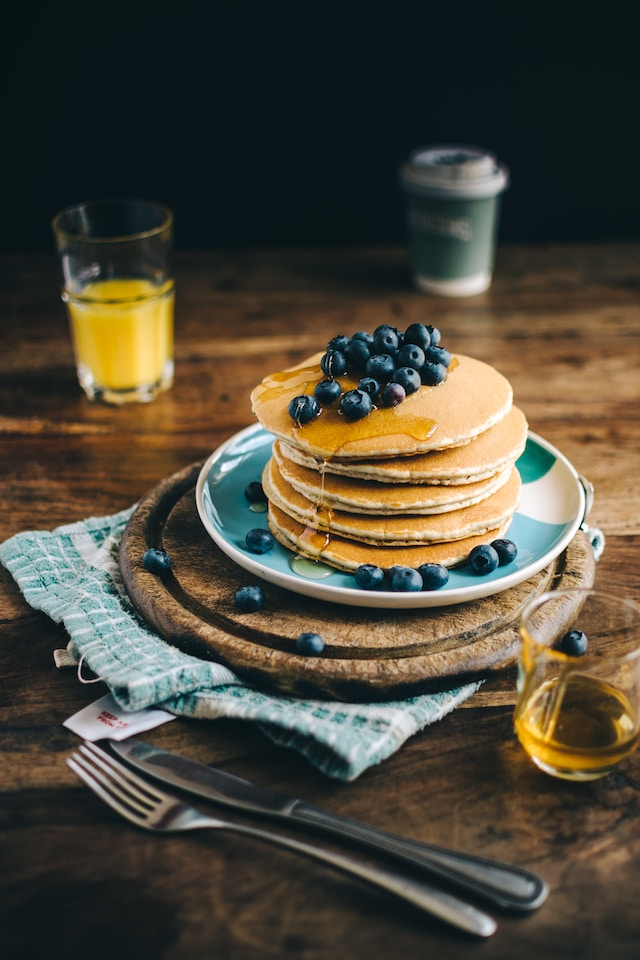

In [24]:
url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image

## prompts 제어

In [25]:
prompts = ["wood", "glass",'fork']

In [26]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

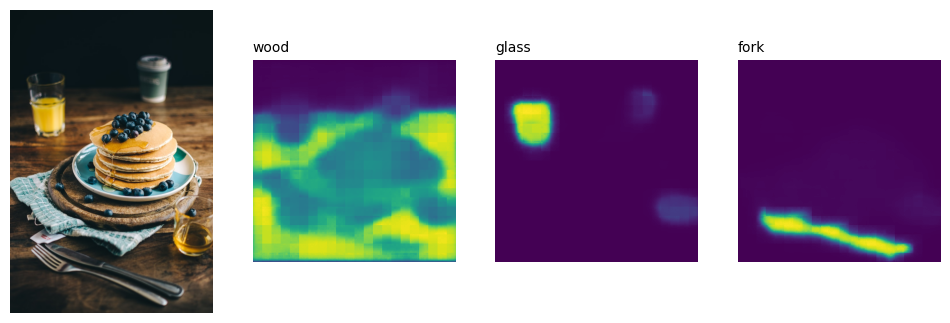

In [27]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];


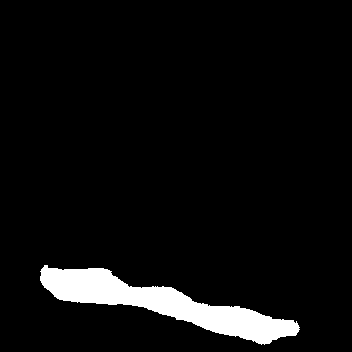

In [32]:
filename = f"mask.png"
# here we save the second mask
plt.imsave(filename,torch.sigmoid(preds[2][0]))
import cv2
img2 = cv2.imread(filename)
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)
Image.fromarray(bw_image)

## 유리컵이있는것처럼 할루시네이션

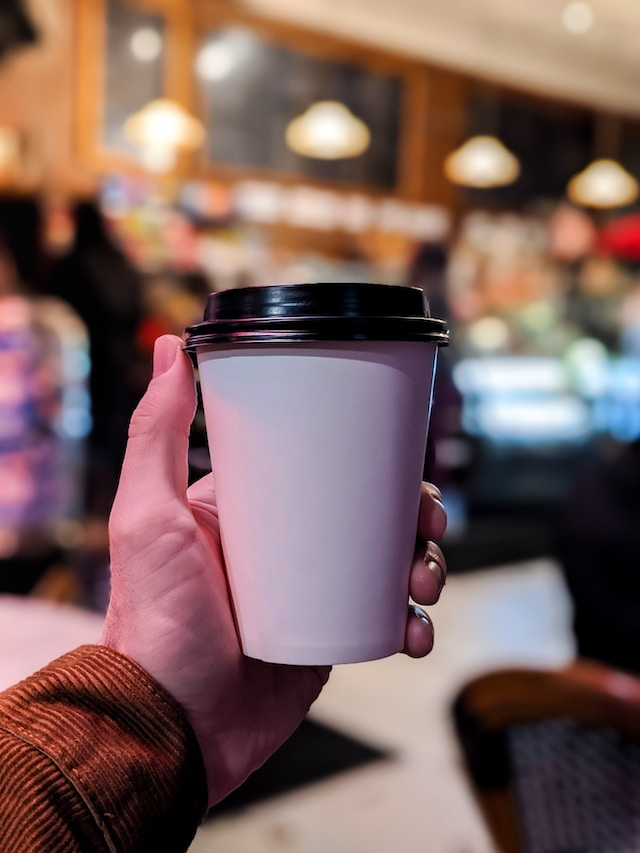

In [8]:
url = "https://unsplash.com/photos/Ki7sAc8gOGE/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTJ8fGNvZmZlJTIwdG8lMjBnb3xlbnwwfHx8fDE2NzExOTgzNDQ&force=true&w=640"
prompt = Image.open(requests.get(url, stream=True).raw)
prompt

In [19]:
encoded_image = processor(images=[image], return_tensors="pt")
encoded_prompt = processor(images=[prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

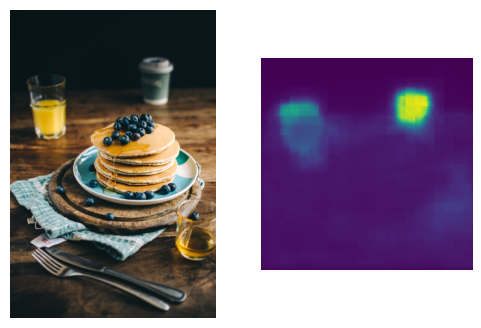

In [20]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))

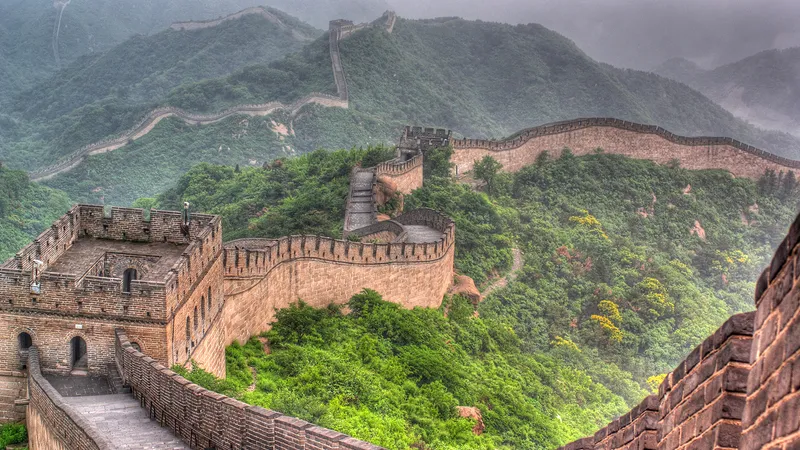

In [34]:
import urllib.request
# urllib.request.urlretrieve(url, './1.jpg')
alternative_prompt = Image.open('china.webp')
alternative_prompt

## 여러이미지 혼합?

In [35]:
encoded_alternative_prompt = processor(images=[alternative_prompt], return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**encoded_image, conditional_pixel_values=encoded_alternative_prompt.pixel_values)
preds = outputs.logits.unsqueeze(1)
preds = torch.transpose(preds, 0, 1)

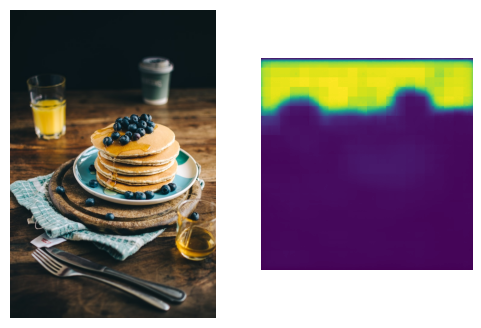

In [36]:
_, ax = plt.subplots(1, 2, figsize=(6, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
ax[1].imshow(torch.sigmoid(preds[0]))

## 파인튜닝

In [37]:
from segments import SegmentsClient
from getpass import getpass

api_key = getpass('Enter your API key: ')
segments_client = SegmentsClient(api_key)

Enter your API key: ··········


## Dataset 받는 용도

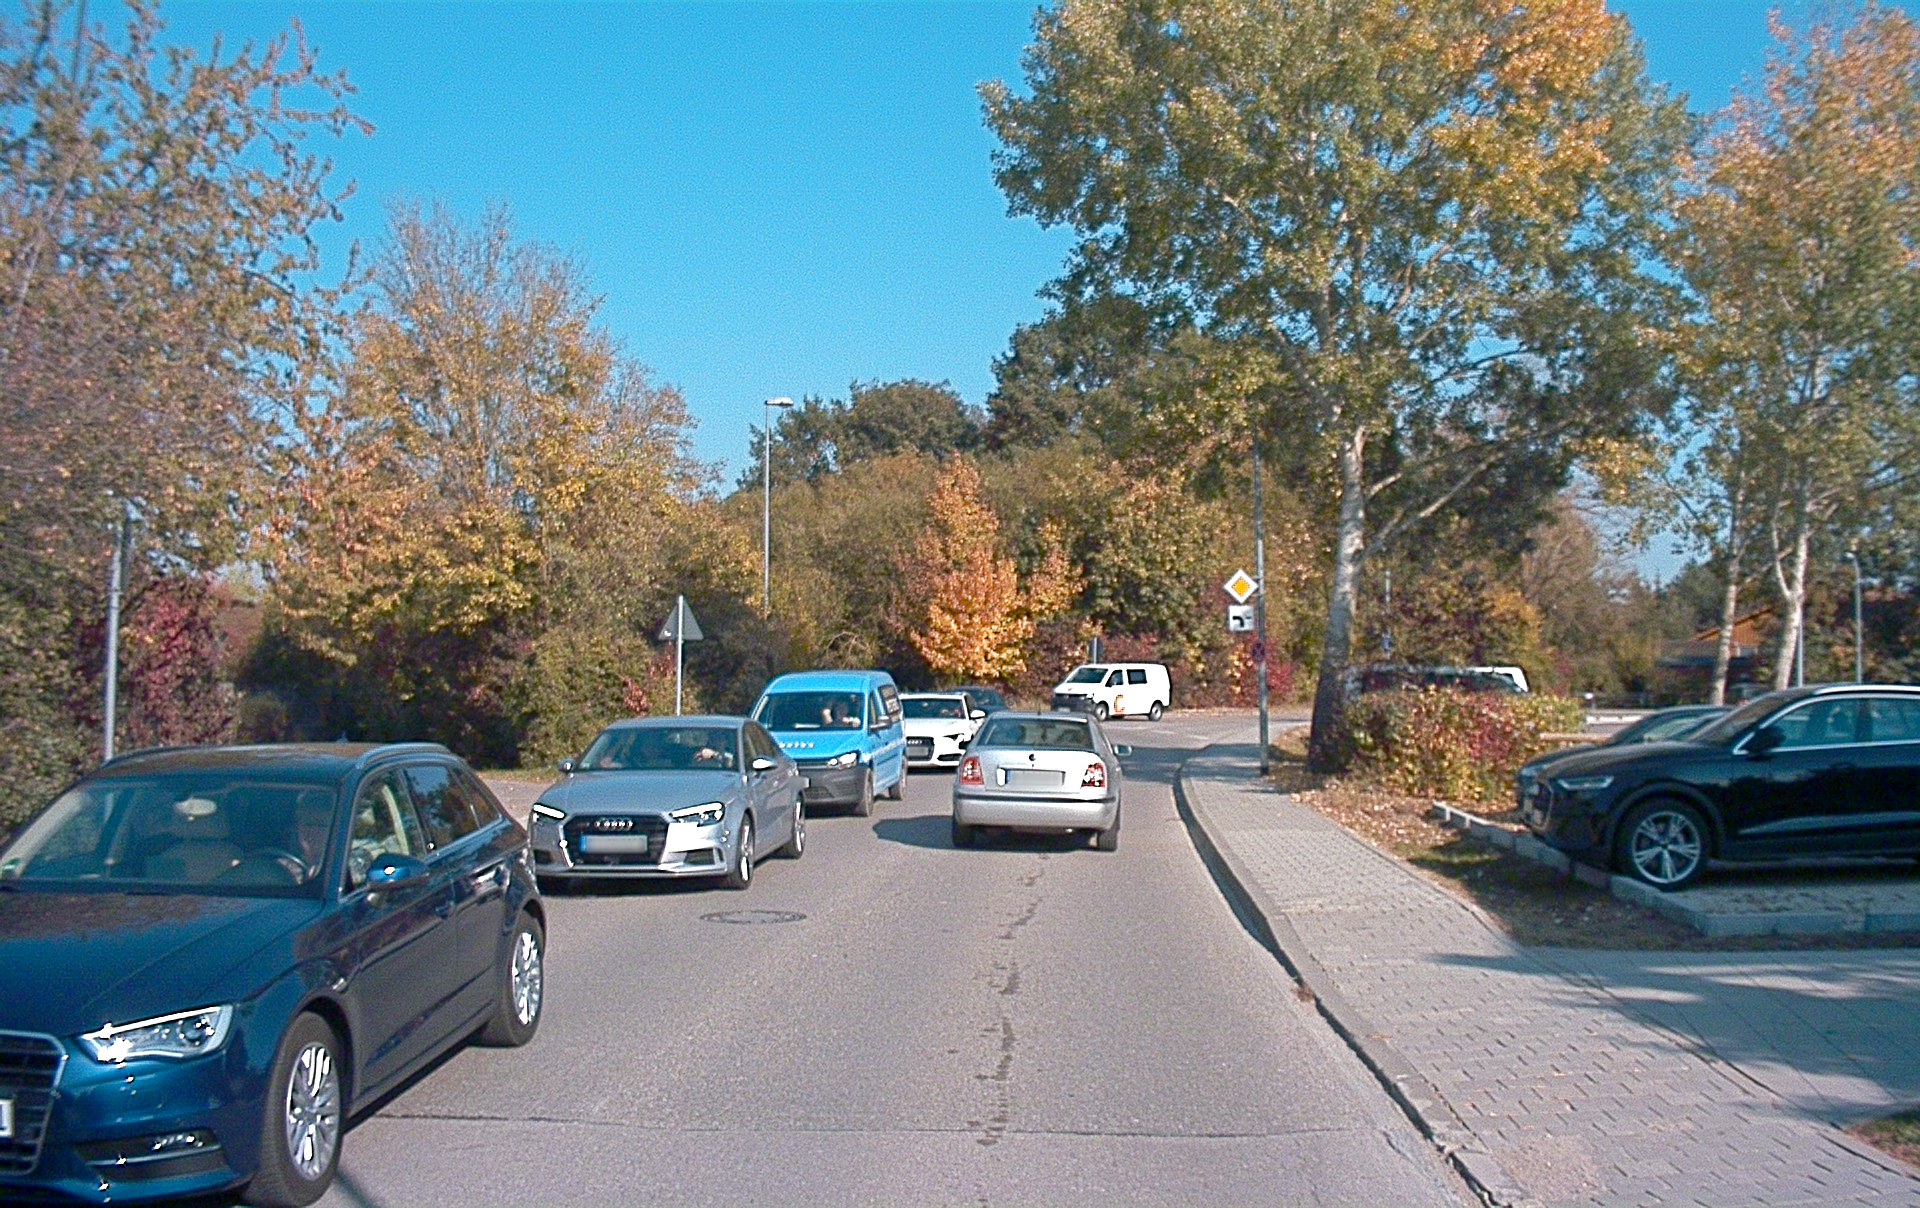

In [38]:
samples = segments_client.get_samples("admin-tobias/clipseg")

# Use the last image as an example
sample = samples[5]
image = Image.open(requests.get(sample.attributes.image.url, stream=True).raw)
image

In [39]:
dataset = segments_client.get_dataset("admin-tobias/clipseg")
category_names = [category.name for category in dataset.task_attributes.categories]

In [40]:
category_names

['car', 'buildings', 'road', 'trees', 'sky']

In [41]:
from torch import nn

inputs = processor(text=category_names, images=[image] * len(category_names), padding="max_length", return_tensors="pt")

# predict
with torch.no_grad():
  outputs = model(**inputs)

# resize the outputs
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)

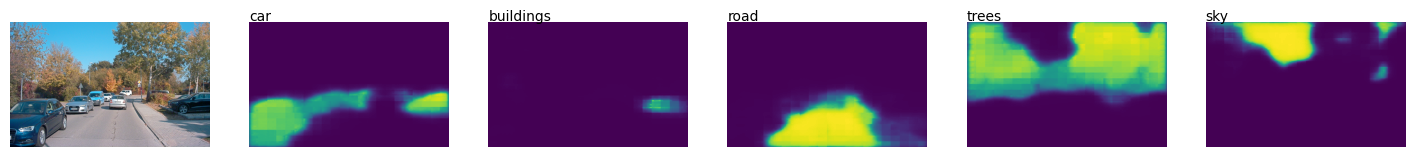

In [42]:
len_cats = len(category_names)
_, ax = plt.subplots(1, len_cats + 1, figsize=(3*(len_cats + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len_cats)];
[ax[i+1].text(0, -15, category_name) for i, category_name in enumerate(category_names)];

## threshold 설정

In [46]:
threshold = 0.4

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

In [47]:
inds

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

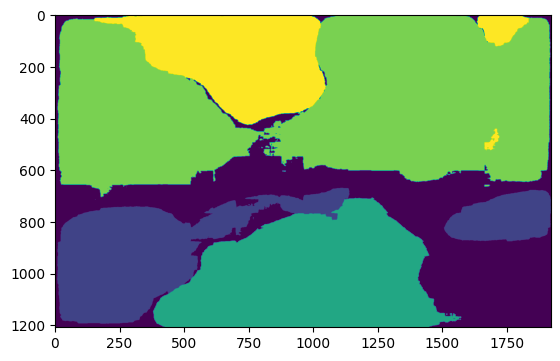

In [48]:
plt.imshow(inds)

In [49]:
# from segments.utils import bitmap2file
# import numpy as np

# inds_np = inds.numpy().astype(np.uint32)
# unique_inds = np.unique(inds_np).tolist()
# f = bitmap2file(inds_np, is_segmentation_bitmap=True)

# asset = segments_client.upload_asset(f, "clipseg_prediction.png")

# attributes = {
#       'format_version': '0.1',
#       'annotations': [{"id": i, "category_id": i} for i in unique_inds if i != 0],
#       'segmentation_bitmap': { 'url': asset.url },
#   }

# segments_client.add_label(sample.uuid, 'ground-truth', attributes)

AuthorizationError: ignored